# <i class="fas fa-circle mandatory"></i> Gaze estimation
<span class="badge badge-pill badge-danger">mandatory</span><span class="badge badge-pill badge-dark">notebook</span>

This is the first mandatory exercise which means you will have to hand in this Jupyter Notebook with your implementation and notes. This exercise is split into multiple parts which have to be submitted together. The submission deadline is available on LearnIT.

## Tasks
The following list is a summary of the tasks you need to complete to pass the exercise. Find the tasks in the exercise text with further instructions on what to do. 

<i class="fas fa-exclamation-circle mandatory"></i> {ref}`gaze:viz` (**A-B**)

<i class="fas fa-exclamation-circle mandatory"></i> {ref}`gaze:implement` (**A-D**)

<i class="fas fa-exclamation-circle mandatory"></i> {ref}`gaze:evaluation` (**A-D**)

<i class="fas fa-exclamation-circle mandatory"></i> {ref}`gaze:improve` (**A-C**)



## Overview

In this exercise you will implement a regression model to estimate where a person is looking (this is known as *gaze*). Gaze estimation is performed by capturing images of a users eye as shown in FIG and mapping them to screen positions. Humans look at things by orienting their eyes so that the point of focus is directly in line with a point on their retinas known as the *fovea* (shown in {numref}`fig-model`). Therefore, the pupil position can be used to infer gaze. 

```{note}
The *fovea* is located slightly differently from person to person ($\pm$ 5 degrees) and as a consequence, a gaze model has to be retrained for every person using it. This difference is shown in {numref}`fig-kappa`.
```


```{figure} ../img/model.png
---
name: fig-model
width: 350px
---
Diagram of a gaze estimation system. The eye, which is directed
at a specific point on the screen is captured by the camera. The two red lines represent an unknown transformation from image to eye and eye to screen. We learn this transformation directly which is shown as $f_{\theta}(x, y)$ in the diagram.
```

In this exercise, $f_{\theta}(x, y)$ is the model mapping pupil positions in images (the $x$ and $y$ parameters) onto screen coordinates (the output of $f_{\theta}$). The model is trained using a set of paired pupil and screen positions. This ground-truth dataset has been collected in advance by asking the participant to look at a specific point on a screen while capturing an eye image. We have detected the pupils for each image using ellipse approximation. 

The next section will introduce you to the dataset.

```{figure} ../img/kappa.jpg
---
name: fig-kappa
figclass: margin
---
Shows the distinction between the visual and optical axes. The optical axis is defined as an axis perpendicular to the lens behind the pupil. The visual axis is personally dependent and is determined by the placement of the *fovea*.
```


### About data

The goal of this exercise is to estimate the gaze of image sequences using a regression model. Each image sequence contains 9 images for calibration and a varying number of images for inference. The calibration samples always represent the same 9 screen positions which form a simple 3 by 3 grid. An example of calibration images are shown in
{numref}`fig-calibration`. For each sequence, you will use the 9
calibration samples to train a regression model and then use the model
to predict gaze positions for the rest of the images.

```{figure} ../img/calibration.jpg
---
name: fig-calibration
width: 60%
---
Calibration images. All image sequences contain 9 calibration images
which all have equivalent gaze positions.
```

`positions.json` contains the ground-truth gaze positions for each image as an array
(stored as $y, x$ for each point). The included image sequences (found
in `inputs/images`) are divided into two groups:

- **No head movement:** `pattern0`, `pattern1`, `pattern2`, `pattern3`

- **Head movement and rotation:** `movement_medium`, `movement_hard`,

You may want to focus on the ones without head movement for now.

In [258]:
import os
import sys
import json
import cv2 as cv
import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import Tuple, NamedTuple, List

import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import interact
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import matthews_corrcoef

```{note}
The real notebook (the one in the materials repository or the one you can download from this page) contains some extra utility code that has been hidden here for brevity. The code is fully commented and we recommend you read it whenever you are in doubt about what is happening.
```

In [259]:
def load_json(folder, filename):
    """Load json file from subdirectory in "inputs/images" with the given filename
    - without .json extension!

    Returns: The json data as a dictionary or array (depending on the file).
    """
    with open(os.path.join(os.path.abspath('../inputs/images/' + folder), f'{filename}.json')) as file:
        data = json.load(file)
        return data

def create_pupil_dataframe(data):
    df = pd.DataFrame(data)
    df.index.name = 'idx'
    return df

def create_glint_dataframe(data):
    rows = [[{'idx': idx, 'num': idx2, 'x': x, 'y': y} for idx2, (x, y) in enumerate(row)] for idx, row in enumerate(data)]
    rows = np.concatenate(rows)
    df = pd.DataFrame.from_records(rows)
    return df

def create_pos_dataframe(data):
    rows = [{'idx': idx, 'x': x, 'y': y} for idx, (x, y) in enumerate(data)]
    df = pd.DataFrame.from_records(rows, index='idx')
    return df

def dist(a, b):
    return np.linalg.norm(a - b)

def center_crop(img, size):
    width, height = size
    i_height, i_width = img.shape[:2]

    dy = (i_height-height)//2
    dx = (i_width-width)//2

    return img[dy: i_height-dy, dx: i_width-dx]



In [260]:
def open_img(path, idx):
    """Open a single image from the provided path. The index specifies the image name."""
    img = cv.imread(path + f'/{idx}.jpg')
    if img is None:
        raise IOError("Could not read image")
    return img

def draw_features(img, feature):
    """Helper for drawing pupil and glints onto an image."""
    frame = img.copy()
    feature.pupil.draw(frame, color=(0, 0, 255), thickness=5)
    feature.glints.draw(frame, color=(0, 255, 0), thickness=3, size=20)
    return frame

def load_dataset(folder):
    """Load all images and screen positions for a valid data folder (any folder in "inputs/images")."""
    path = os.path.abspath('../inputs/images/' + folder)

    positions = np.array(load_json(path, 'positions'))
    images = [open_img(path, i) for i in range(len(positions)-1)]

    return list(map(lambda x: Sample(*x), zip(images, positions)))

def predict_features(dataset):
    """Predict eye image features for all images in `dataset`. The dataset is a list of Sample instances."""
    res = []
    for sample in dataset:
        pupil = find_pupil(sample.image)
        glints = find_glints(sample.image, pupil.center)
        res.append(FeatureDescriptor(pupil, glints))
    return res

def show_example_features(images, pupils):
    """Draw a grid of images with the predicted pupils drawn on top."""
    n = len(images)
    cols = 8
    rows = n//8+1

    fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i, d in enumerate(images):
        img = d.copy()
        row = pupils.iloc[i]
        img = cv.ellipse(img, (int(row['cx']), int(row['cy'])), (int(row['ax']/2), int(row['ay']/2)), row['angle'], 0, 360, (255, 0, 0), 5)
        ax[i//cols, i%cols].imshow(center_crop(img, (250, 250)))
    for row in ax:
        for a in row:
            a.get_xaxis().set_visible(False)
            a.get_yaxis().set_visible(False)
    plt.show()

(gaze:viz)=
## <i class="fas fa-exclamation-circle mandatory"></i> Data and visualization
First you will familiarise yourself with the problem domain and data sources by doing a number of visualisations. 

The code below loads all the datasets specified in `inputs` and predicts features for each image. The `show_example_features` function then plots a grid of all the images from one of the datasets. 

**A): <i class="fas fa-code"></i>** Test the visualisation for different datasets (by changing the array index when accessing images, positions, or pupils).

In [261]:
# Enter dataset folder name here (any subfolder in inputs/images will do)
dataset_folders = ['pattern0', 'pattern1', 'pattern2', 'moving_medium', 'moving_hard']

# Load detected pupil features
pupils = [create_pupil_dataframe(load_json(f, 'pupils')) for f in dataset_folders]
# Load screen gaze positions
positions = [create_pos_dataframe(load_json(f, 'positions')) for f in dataset_folders]
# Load eye images
images = [[open_img(os.path.abspath('../inputs/images/' + f), i) for i in range(len(p)-1)] for p, f in zip(positions, dataset_folders)]

In [262]:
# Create train and test splits
pupils_train = [df.iloc[:9] for df in pupils]
pupils_test = [df.iloc[9:] for df in pupils]
positions_train = [df.iloc[:9] for df in positions]
positions_test = [df.iloc[9:] for df in positions]
images_train = [li[:9] for li in images]
images_test = [li[9:] for li in images]

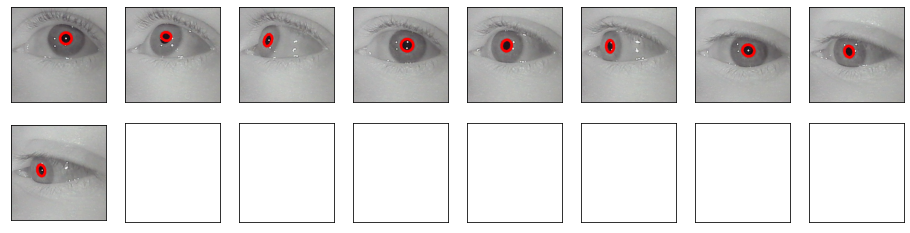

In [263]:
show_example_features(images_train[0], pupils_train[0])

In [264]:
# A) Testing visualization for different datasets
#show_example_features(images_train[2], pupils_train[2])
#show_example_features(images_train[1], pupils_train[1])

Lets visualize the recorded screen gaze positions. The subject was instructed to look at a red dot on a specific point on a screen while the camera captured each image. We provide the visualisation code for this part:

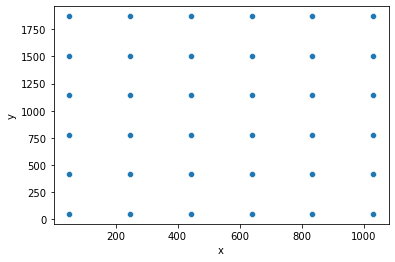

In [265]:
sns.scatterplot(x='x', y='y', data=positions_test[0]);

In [266]:
#A) Testing the visualiazation of the positions.
#sns.scatterplot(x='x', y='y', data=positions_test[2]);
#sns.scatterplot(x='x', y='y', data=positions_test[1]);

**B): <i class="fas fa-code"></i>** Test the visualisation for different datasets (by changing the array index when accessing images, positions, or pupils). Do the same but for the detected pupil positions. We provide the `DataFrame` object for each so you should be able to simply modify the example above

In [267]:
data = pupils[0].head()
# Write the plotting code here (using Seaborn is easier, but feel free to use Matplotlib as well)
#np.array(pupils[3][['cx','cy']])


(gaze:implement)=
## <i class="fas fa-exclamation-circle mandatory"></i> Implement a gaze estimation model

```{figure} ../img/gaze2.jpg
---
name: fig-gaze
figclass: margin
---
Calibration images. All image sequences contain 9 calibration images
which all have equivalent gaze
positions.
```

The mapping function $f_\theta(x, y)$ as shown in
{doc}`../main` is unknown. Because the pupil moves in a spherical curve (this is only true when the head is fixed), the relationship between pupil position in the image and gaze is non-linear. In this exercise, however, you will approximate the gaze mapping by a linear function. Because the function has two outputs, it is easier to train one model for each coordinate. You do this as in the exercises but with one model for the $x$ coordinate and one for the $y$
coordinate. To get the screen coordinates $x'$, $y'$ we have

$$
\begin{aligned}
x' &= ax + by + c\\
y' &= dx + ey + f
 \end{aligned}
$$

**A): <i class="fas fa-pen"></i>** **Construct the design matrix:** Write design matrices for both equations above. Use the previous exercises as a guideline. Answer the following:
- What are the knowns and unknowns in the equations?

Answer: The knowns are x and y representing the pupils, and the unknowns are a,b,c,d,e,f which represents the parameters.

- How many parameters does the model have?

Answer: For both eaquations we have a total of 6 parameters

- How many points (pupil to gaze point correspondances) do we need to solve the equations?

Answer: To solve the equations we need 3 point

- What effect does the number of points used have on the solution?

Answer: More points means more information and thefore we will get better prediction if the points are not outliers.

The principle is demonstrated in {numref}`fig-gaze` to the right. Here, the $x$ coordinate of the pupil maps to the $x$ coordinate on the screen. In the real model, we use both $x$ and $y$ as inputs to both the model estimating the $x$ position on the screen and the model estimating the $y$ position.

**B): <i class="fas fa-code"></i>** **Implement the design matrix:** Implement a function for generating a design matrix from pupil positions and a function for calculating the linear function given a parameter vector and an input vector. For reference, the linear model has the form $f(x; \theta)=\theta_0 x_0 + \theta_1 x_1 + \theta_2$

**C): <i class="fas fa-code"></i>** **Calibration:** Learn the parameters $\theta$ for the linear regression using the `pupils_train` and `positions_train` lists (remember to select one of the datasets in the lists). Create a design matrix from the pupil positions. Use *two* linear models, as described above, one to learn the X-coordinates and one to learn the Y-coordinates. 

```{note}
This is possibly the most difficult part of the exercise. Try to use what you learned in the two non-mandatory exercises and apply it here. Remember that you need to fit two separate models, one for each screen coordinate.
```

**D): <i class="fas fa-code"></i>** **Estimation:** Implement a function which predicts the gaze given a pupil position using the learned model. Then calculate and return the estimated screen coordinates using the models created during calibration.

In [268]:
# Refining the train datasets
def get_pupils_train(idx):
    pupils= np.array(pupils_train[idx][['cx','cy']])
    return pupils
def get_positions_train(idx):
    position= np.array(positions_train[idx][['x','y']])
    return position

Design Matrix
[design matrix].[params]= x_vector
$$ \begin{aligned} x^* &= c + by + ax  \end{aligned} $$

$$
\begin{bmatrix}
 		1 & y_1 & x_1\\
  		1 & y_2 & x_2\\
  		\vdots & \\
   		1 & y_n & x_n\\
 	\end{bmatrix}. \begin{bmatrix}
 		c \\
  		b \\
   		a\\
 	\end{bmatrix}.= \begin{bmatrix}
 		x_1^* \\
  		x_2^* \\
  		\vdots\\
   		x_n^* \\
 	\end{bmatrix}.
$$

[design matrix].[params]= y_vector
$$ \begin{aligned} y^* &= f + ey + dx  \end{aligned} $$

$$
\begin{bmatrix}
 		1 & y_1 & x_1\\
  		1 & y_2 & x_2\\
  		\vdots & \\
   		1 & y_n & x_n\\
 	\end{bmatrix}. \begin{bmatrix}
 		f \\
  		e \\
   		d\\
 	\end{bmatrix}.= \begin{bmatrix}
 		y_1^* \\
  		y_2^* \\
  		\vdots\\
   		y_n^* \\
 	\end{bmatrix}.
$$



In [269]:
#5.3.4.  Implement a gaze estimation mode

# A)  Construction of the design matrix for the pupils_train Dataset 
def get_design_matrix(idx):
    order=1
#Get the shape of the resulting train matrix and fill with one
    count = get_pupils_train(idx).shape[0]
    matrix = np.ones((count, order + 1), np.float64)

    cy = get_pupils_train(idx)[:,1]
    for i in range(1, order+1):
       matrix[:, i] = np.power(cy, i)
            
         
    cx = get_pupils_train(idx)[:,0] 
    design_matrix = np.column_stack((matrix, cx))
       
    return design_matrix

get_design_matrix(0)

array([[  1.        , 197.01445007, 339.51727295],
       [  1.        , 192.63760376, 303.10678101],
       [  1.        , 202.16972351, 271.50030518],
       [  1.        , 215.5239563 , 337.41473389],
       [  1.        , 216.23629761, 299.1817627 ],
       [  1.        , 218.3691864 , 271.81896973],
       [  1.        , 229.85021973, 335.58258057],
       [  1.        , 232.27362061, 300.77288818],
       [  1.        , 234.39505005, 274.34417725]])

In [270]:
#B)Function calculating the linear function given a parameter vector and an input vector
def linear_function(pupil,params):
    c,b,a = params
    cx,cy = pupil
    result = cx*a+cy*b+c
    return result

In [271]:
# C) Calibration: Learn the parameters  𝜃  for the linear regression

#Get the parameters for x′=ax+by+c using the x coordinate of gaze pozitions_train dataset as y (Only for train dataset)

def model_X(idx):
    A = get_design_matrix(idx)
    y=  get_positions_train(idx)[:,0]
    params = np.linalg.lstsq(A, y, rcond=None)[0]
    return params

#Get the parameters for y′=dx+ey+f using the Y coordinate of gaze pozition as a my y at the equation below.
def model_Y(idx):
    A = get_design_matrix(idx)
    y=  get_positions_train(idx)[:,1]
    params = np.linalg.lstsq(A, y, rcond=None)[0]
    return params

#model_X(0)
model_Y(0)

array([ 9.57251528e+03, -7.27880927e-01, -2.78430276e+01])

In [272]:
#D: Estimation:
#Prediction function

def gaze_prediction(pupils_test,idx):
    data=[]
    for i in pupils_test:
        params_x = model_X(idx)
        x= linear_function(i,params_x)

        params_y = model_Y(idx)
        y= linear_function(i,params_y)
        a = [x,y]
        data.append(a)
    return data

(gaze:evaluation)=
## <i class="fas fa-exclamation-circle mandatory"></i> Evaluation of the regression model

In [273]:
#Preparing pupils_test and positions_test dataset to facilitate the usage
def get_pupils_test(idx):
    pupils = np.array(pupils_test[idx][['cx','cy']])
    return pupils

def get_positions_test(idx):
    position_test= np.array(positions_test[idx][['x','y']])
    return position_test


**A): <i class="fas fa-code"></i>** **Calculate errors:** For each dataset, predict gaze positions and calculate the *mean squarred error* between the true values in `positions_test` and the predictions. Additionally:
- Calculate the square root of the *mse* for each dataset.

**B): <i class="fas fa-code"></i>** **Calculate distance errors:**
- Calculate the euclidean distance between each predicted point and ground truth screen position. 
- Calculate the mean and variance of the distance error for each dataset. 
- Calculate the distance error for $x$ and $y$ seperately (this is just the absolute value of the error). Then calculate the correlation for the $x$ and $y$ errors for each dataset.
- <i class="fas fa-pen"></i> What does the correlation tell you of the error for each coordinate?

Answer: 

- Visualise the results using a suitable choice of plots (only include plots you think show something valuable about the results).
- <i class="fas fa-pen"></i> Explain why the distance metric is useful for this particular model.

Answer: 


**C): <i class="fas fa-pen"></i>** **Evaluate:**
- How does the model perform? Use both metrics and your visualisations to evaluate the performance.
- Explain your results in the notebook. Don't just save them in variables. 
- Explain any significant differences between the results for each dataset? 
- What would happen if you used the same corresponding points (i.e. dataset) for both training and testing?

**D): <i class="fas fa-code"></i>** **Create visualizations:** Create scatterplots similar to the ones shown earlier in the exercise, but with both ground truth `positions` and predictions. Answer the following:
- <i class="fas fa-pen"></i> Is the linear model a suitable model for this problem? Why/why not? 
- <i class="fas fa-pen"></i> What is the quality of the pupil input points? Are they accurate? What effect does their accuracy have on the final error?


(gaze:improve)=
## <i class="fas fa-exclamation-circle mandatory"></i> Improve the model
Hopefully, you have observed by now that the linear model is not entirely adequate to capture the movement of the pupil. You should understand why this is the case.

This final part of the exercise requires you to modify your linear model into a quadratic model. You have tried this before in one dimension, but here we have two. As before, you will still create one model for each output dimension.

```{note}
It is perfectly possible to create a single model that captures all inputs and outputs. However, we leave it as an optional extra exercise for you to figure out how to do this. Hint: You have to combine the design and parameter matrices in some way for this to work.
```

Since the model is two-dimensional, the quadratic polynomial has a few more factors than for one dimension. The equation for each axis is:

$$
f(x, y) = a\cdot x^2 + b\cdot y^2 + c\cdot xy + d\cdot x + e\cdot y + f.
$$

The design matrices then have the following form:

$$
D_x = D_y = \begin{bmatrix}
 		x_1^2 & y_1^2 & x_1y_1 & x_1 & y_1 & 1\\
  		x_2^2 & y_2^2 & x_2y_2 & x_2 & y_2 & 1\\
  		\vdots &&&&& \\
   		x_2^2 & y_2^2 & x_ny_n & x_n & y_n & 1\\
 	\end{bmatrix}.
$$(dmat)


**A): <i class="fas fa-code"></i>** **Implement model:** Create a new calibration and prediction method that uses quadratic models.

**B): <i class="fas fa-code"></i>** **Evaluate:** Calculate the *rmse* and distance errors as before and compare the two. Visualise errors like you did for the linear model.

**C):** **Compare with linear results:**
- <i class="fas fa-code"></i> Repeat the evaluation steps for the linear model, i.e. calculate the same metrics and plots. Try to combine the plots for both models to make comparisons easier.
- <i class="fas fa-pen"></i> Use distance means and variance to compare the performance of the linear and quadratic models.
- <i class="fas fa-pen"></i> Which model is best in certain situations and why? Relate this to your knowledge of the problem domain (gaze estimation) and the general problem of choosing model complexity.

5.3.5.  Evaluation of the regression model

In [274]:

def variance(values):
    
    mean = np.sum(values) / len(values)
    return np.sum(np.power(values - mean, 2)) / (len(values) - 1)

def get_axis_error_correlation(x_y_errors):
    return np.corrcoef(x_y_errors.to_numpy(), rowvar=False)[0,1]

def get_absolute_errors(estimated_positions, ground_truth):
    abs_errs = np.absolute(estimated_positions - ground_truth)
    return pd.DataFrame({'x_err': abs_errs[:, 0], 'y_err': abs_errs[:, 1]})


Dataset 'pattern0
__________________________________________________________'
Mean squarred error:  433234285.66393137
Root mean squarred error:  20814.28081063411
Euclidean distance:  176615.0292806449
Mean:  15965.884773988866
Correlation:  0.06922586594124615


Dataset 'pattern1
__________________________________________________________'
Mean squarred error:  313792750.26037574
Root mean squarred error:  17714.19629168582
Euclidean distance:  100206.6265689651
Mean:  14963.252166229071
Correlation:  0.03498440056859501


Dataset 'pattern2
__________________________________________________________'
Mean squarred error:  294345506.0118817
Root mean squarred error:  17156.500401069028
Euclidean distance:  121314.77775025633
Mean:  13640.680054373872
Correlation:  -0.13232563734650307


Dataset 'moving_medium
__________________________________________________________'
Mean squarred error:  434129472.2764141
Root mean squarred error:  20835.77385835271
Euclidean distance:  176797.4038381

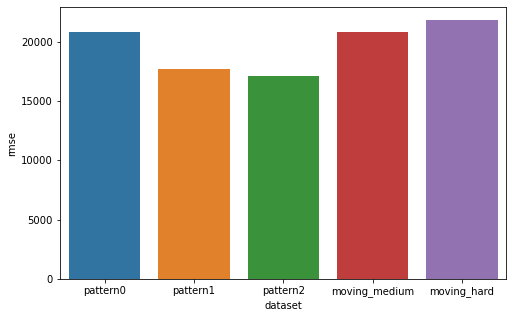

In [275]:
def gaze_evaluations():
    mse = np.zeros(len(pupils_test))
    rmse = np.zeros(len(pupils_test))
    dis = np.zeros(len(pupils_test))
    ds_err_variance = np.zeros(len(pupils_test))
    prediction = 0
    for i in range(len(dataset_folders)):
        prediction = gaze_prediction(get_positions_test(i),i)
        print(f"Dataset '{dataset_folders[i]}\n__________________________________________________________'")
        r = mean_squared_error(get_positions_test(i), prediction)
        mse[i] = r
        r2 = np.sqrt(r)
        rmse[i] = r2
        euclidean_dist = np.linalg.norm(get_positions_test(i)-prediction)
        mae = mean_absolute_error(get_positions_test(i), prediction)
        absolute_errors = get_absolute_errors(prediction, get_positions_test(i))
        correlation = get_axis_error_correlation(absolute_errors)
        
        print("Mean squarred error: ", r)
        print("Root mean squarred error: ", r2)
        print("Euclidean distance: ", euclidean_dist)
        print("Mean: ", mae)
        print("Correlation: ",correlation)
        print("\n")
    
    quads = np.zeros(len(pupils_test))
    mean_errors = pd.DataFrame({'rmse': rmse, 'dataset': dataset_folders, 'quad': quads})
    plt.figure(figsize=(8,5))
    sns.barplot(x="dataset", y="rmse", data=mean_errors)
    
gaze_evaluations()

The graph above shows a bar plot with the rmse values for the each datasets, we can see that the residuals a very far from the mean. Meaning that perhaps we could try to inprove the model to have a better fit of the regression line and minimize rmse.

What does the correlation tell you of the error for each coordinate?

Answer:Correlation tells whether two variables has linear relationship, above I listed the correlations for each dataset, the data shows that a week correlation as the values are far from 1 or -1.

Answer: Its important because the fact that the pupils actually projects in circular montion and we have a linear model. So the distance metrics will tell us how bad is the error between the predition and the actual position values.

plotting the real value of gaze for test dataset and prediction for pupils_test 
The blue points shows the true values and the orange is the predition


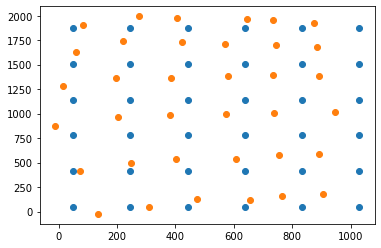

In [276]:
#EVALUATE

#plotting the real value of gaze for test dataset and prediction for pupils_test 
real_values=get_positions_test(0)
x = real_values[:,0]
y = real_values[:,1]

linear_prediction= gaze_prediction(get_pupils_test(0),0)
h= np.squeeze(np.array([linear_prediction]))
x1 = h[:,0]
y1 = h[:,1]
print("plotting the real value of gaze for test dataset and prediction for pupils_test ")
print("The blue points shows the true values and the orange is the predition")
plt.scatter(x, y)
plt.scatter(x1, y1)
plt.show()

The vizualization below show gaze position for train test to show what happen if we test the model with the same dataset used to train the model. 
We can see bellow that the predition doesn't tells us much about how good the model is. So it is a bad pratice to test the model with the train dataset.

Visualization with train dataset prediction 


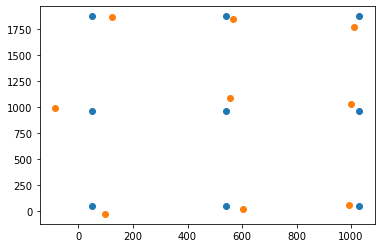

In [277]:
#Visualization with train dataset prediction
real_train_values= get_positions_train(0)
x_train = real_train_values[:,0]
y_train = real_train_values[:,1]

train_prediction= gaze_prediction(get_pupils_train(0),0)
hs= np.squeeze(np.array([train_prediction]))
x_train_prediction = hs[:,0]
y_train_prediction = hs[:,1]
print("Visualization with train dataset prediction ")
plt.scatter(x_train, y_train)
plt.scatter(x_train_prediction, y_train_prediction)
plt.show()

D) Is the linear model a suitable model for this problem? Why/why not?
Answer: The linear model is not suitable for this problem because the atonomy of the eyes rather circular so a linear model is not a good choice.

 What is the quality of the pupil input points? Are they accurate? What effect does their accuracy have on the final error?
    
Answer: I think the quality of input is good and accurate , it gives as a good model as long as we do not mix the head moviment data with non head moviment dataset.

 5.3.6 Improve the model¶


$$
f(x, y) = f+ e\cdot y  +  d\cdot x + c\cdot xy+  b\cdot y^2  + a\cdot x^2.
$$


$$
\begin{bmatrix}
 		1 &  y_1& x_1&  x_1y_1 & 1^2 & x_1^2 \\
  		1 &  y_2  & x_2& x_2y_2  &y_2^2 & x_2^2 \\
  		\vdots &&&&& \\
   		1& y_n & x_n& x_ny_n& y_n^2  & x_n^2 \\
 	\end{bmatrix}.\begin{bmatrix}
 		f\\
  		e\\
   		d\\
   		c\\
   		b\\
   		a\\
 	\end{bmatrix}.= \begin{bmatrix}
 		x_1^* \\
  		x_2^* \\
  		\vdots\\
   		x_n^* \\
 	\end{bmatrix}.
$$

$$
\begin{bmatrix}
 		1 &  y_1& x_1&  x_1y_1 & 1^2 & x_1^2 \\
  		1 &  y_2  & x_2& x_2y_2  &y_2^2 & x_2^2 \\
  		\vdots &&&&& \\
   		1& y_n & x_n& x_ny_n& y_n^2  & x_n^2 \\
 	\end{bmatrix}.\begin{bmatrix}
 		f\\
  		e\\
   		d\\
   		c\\
   		b\\
   		a\\
 	\end{bmatrix}.= \begin{bmatrix}
 		y_1^* \\
  		y_2^* \\
  		\vdots\\
   		y_n^* \\
 	\end{bmatrix}.
$$




In [278]:
#Design matrix for quadratic function

def get_design_matrix_q(idx):
    order=1
    count = get_pupils_train(idx).shape[0]
    matrix = np.ones((count, order + 1), np.float64)
    cy = get_pupils_train(idx)[:,1] 
    for i in range(1, order+1):
       matrix[:, i] = np.power(cy, i)
            
         
    cx = get_pupils_train(idx)[:,0]
    design_matrix = np.column_stack((matrix, cx))
    design_matri = np.column_stack((design_matrix, cx*cy))
    design_matr = np.column_stack((design_matri,cy**2))
    design_mat = np.column_stack((design_matr,cx**2))
    return design_mat

get_design_matrix_q(0)

array([[1.00000000e+00, 1.97014450e+02, 3.39517273e+02, 6.68898088e+04,
        3.88146935e+04, 1.15271979e+05],
       [1.00000000e+00, 1.92637604e+02, 3.03106781e+02, 5.83897640e+04,
        3.71092464e+04, 9.18737207e+04],
       [1.00000000e+00, 2.02169724e+02, 2.71500305e+02, 5.48891416e+04,
        4.08725971e+04, 7.37124157e+04],
       [1.00000000e+00, 2.15523956e+02, 3.37414734e+02, 7.27209584e+04,
        4.64505757e+04, 1.13848703e+05],
       [1.00000000e+00, 2.16236298e+02, 2.99181763e+02, 6.46939567e+04,
        4.67581364e+04, 8.95097271e+04],
       [1.00000000e+00, 2.18369186e+02, 2.71818970e+02, 5.93568873e+04,
        4.76851016e+04, 7.38855523e+04],
       [1.00000000e+00, 2.29850220e+02, 3.35582581e+02, 7.71337299e+04,
        5.28311235e+04, 1.12615668e+05],
       [1.00000000e+00, 2.32273621e+02, 3.00772888e+02, 6.98616077e+04,
        5.39510348e+04, 9.04643303e+04],
       [1.00000000e+00, 2.34395050e+02, 2.74344177e+02, 6.43049172e+04,
        5.49410395e+04, 

In [279]:
def quadratic_function(pupil,params):
    f,e,d,c,b,a = params
    cx,cy = pupil
    result = a*(cx**2)+b*(cy**2)+c*(cx*cy)+d*cx+e*cy+f
    return result

In [280]:
def quadratic_model_X(idx):
    A = get_design_matrix_q(idx)
    y=  get_positions_train(idx)[:,0]
    params = np.linalg.lstsq(A, y, rcond=None)[0]
    return params

#Get the parameters for y′=dx+ey+f using the Y coordinate of gaze pozition as a my y at the equation below.
def quadratic_model_Y(idx):
    A = get_design_matrix_q(idx)
    y=  get_positions_train(idx)[:,1]
    paramss = np.linalg.lstsq(A, y, rcond=None)[0]
    return paramss

#quadratic_model_X(0)
#quadratic_model_Y(0)

In [281]:
def gaze_prediction_q(pupils_test, idx):
    datax=[]
    for i in pupils_test:
        params_x = quadratic_model_X(idx)
        x= quadratic_function(i,params_x)

        params_y = quadratic_model_Y(idx)
        y= quadratic_function(i,params_y)
        a = [x,y]
        datax.append(a)
    return datax

Evaluation

In [282]:

def variance_q(x,y,idx):
    h= gaze_prediction_q(x,idx)
    dist= metrics.mean_absolute_error(y,h)
    vax=np.var(dist)
    return vax



Dataset 'pattern0
__________________________________________________________'
Quadratic model evaluation
Mean squarred error:  81617578788.59569
Root mean squarred error:  285687.9045192423
Euclidean distance:  2424142.255062374
Mean:  195081.74264220247
Correlation:  0.9895565309674234


Dataset 'pattern1
__________________________________________________________'
Quadratic model evaluation
Mean squarred error:  6351052647.95859
Root mean squarred error:  79693.49187956686
Euclidean distance:  450814.46819581435
Mean:  53959.02635485787
Correlation:  0.46256745634534707


Dataset 'pattern2
__________________________________________________________'
Quadratic model evaluation
Mean squarred error:  8588077680.736719
Root mean squarred error:  92671.88182365091
Euclidean distance:  655289.1606282191
Mean:  53997.6332623279
Correlation:  0.844353266734137


Dataset 'moving_medium
__________________________________________________________'
Quadratic model evaluation
Mean squarred error:  1

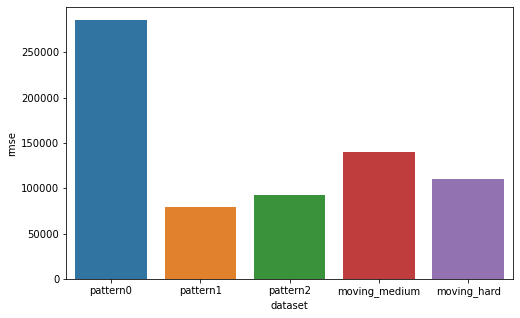

In [283]:
def gaze_evaluations2():
    mse = np.zeros(len(pupils_test))
    rmse = np.zeros(len(pupils_test))
    dis = np.zeros(len(pupils_test))
    ds_err_variance = np.zeros(len(pupils_test))
    prediction = 0
    for i in range(len(dataset_folders)):
        print("Quadratic model evaluation")
        prediction = gaze_prediction_q(get_positions_test(i),i)
        print(f"Dataset '{dataset_folders[i]}\n__________________________________________________________'")
        r = mean_squared_error(get_positions_test(i), prediction)
        mse[i] = r
        r2 = np.sqrt(r)
        rmse[i] = r2
        euclidean_dist = np.linalg.norm(get_positions_test(i)-prediction)
        mae = mean_absolute_error(get_positions_test(i), prediction)
        absolute_errors = get_absolute_errors(prediction, get_positions_test(i))
        correlation = get_axis_error_correlation(absolute_errors)

        print("Mean squarred error: ", r)
        print("Root mean squarred error: ", r2)
        print("Euclidean distance: ", euclidean_dist)
        print("Mean: ", mae)
        print("Correlation: ",correlation)
        print("\n")

    print("Barplot with rmse values for all datasets")
    quads = np.zeros(len(pupils_test))
    mean_errors = pd.DataFrame({'rmse': rmse, 'dataset': dataset_folders, 'quad': quads})
    plt.figure(figsize=(8,5))
    sns.barplot(x="dataset", y="rmse", data=mean_errors)

gaze_evaluations2()

The graph above shows rmse data for all dataset, and we can see that  the residuals a closer to the mean, it has much better results than the linear model,
and has a strong uphill (positive) correlation meaning that the points lie closer to the line.

The Quadratic model provides better prediction than the linear because of the caracteristics of the problem.
AS mensioned before the eyes moviment seams circular so it is hard to use a linear model that find values close to the true values, but the quadratic function is always a parabola so it will be a best fit for this problem of finding gaze position.

plotting the real value of gaze for test dataset and test prediction to see the error


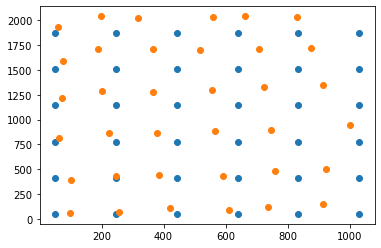

In [284]:
#plotting the real value of gaze for test dataset and test prediction to see the error

real_valuess=get_positions_test(0)
xq = real_values[:,0]
yq = real_values[:,1]

linear_prediction= gaze_prediction_q(get_pupils_test(0),0)
h= np.squeeze(np.array([linear_prediction]))
x2 = h[:,0]
y2 = h[:,1]
print("plotting the real value of gaze for test dataset and test prediction to see the error")
plt.scatter(xq, yq)
plt.scatter(x2, y2)
plt.show()

The graph above vizualize the error by comparing the preditions in orange and the true values in blue using the quadratic model.